## Data Preparation 

### Load packages

In [1]:
## basic packages
import pandas as pd
import numpy as np
import re
from datetime import datetime
import time

## data scrapping
import io, json
import requests
from bs4 import BeautifulSoup
import csv

## plotting tools
from wordcloud import WordCloud
import collections
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
%matplotlib inline

!pip install heatmapz

## machine learning tools
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, minmax_scale
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, roc_curve, recall_score, f1_score, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
!pip install shap
import shap

## Filter warnings
import warnings
warnings.filterwarnings('ignore')

!pip install category_encoders
import category_encoders

     |████████████████████████████████| 564 kB 6.7 MB/s 
     |████████████████████████████████| 82 kB 479 kB/s 


In [2]:
weather_df = pd.read_csv('WeatherData20years.csv')

In [3]:
waze_df = pd.read_csv('Waze_City_Irregularity_Data.csv')

## Data cleanning

### Weather Data Cleanning

In [4]:
weather_df.describe()

,dt,timezone,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id
count,2.008910e+05,200891.000000,2.008910e+05,2.008910e+05,200891.000000,200891.000000,200891.000000,200891.000000,200891.000000,0.0,0.0,200891.000000,200891.000000,200891.000000,13409.000000,498.000000,7380.000000,323.000000,200891.000000,200891.000000
mean,1.288289e+09,-22946.736290,3.883388e+01,-1.048214e+02,282.943733,280.861866,280.931827,284.853067,1017.876859,NaN,NaN,51.753229,3.655968,168.070013,0.802609,2.554819,0.419081,0.900588,34.159435,752.778815
std,1.996860e+08,1742.000894,9.774250e-11,2.015104e-10,10.961915,12.176231,11.093824,10.850933,7.012385,NaN,NaN,25.000042,2.763001,119.117429,1.443521,5.142969,0.380056,0.919187,35.348005,115.255693
min,9.466848e+08,-25200.000000,3.883388e+01,-1.048214e+02,247.370000,240.370000,240.320000,247.400000,979.000000,NaN,NaN,2.000000,0.000000,0.000000,0.100000,0.250000,0.100000,0.280000,0.000000,200.000000
25%,1.112834e+09,-25200.000000,3.883388e+01,-1.048214e+02,274.380000,271.280000,272.330000,276.370000,1014.000000,NaN,NaN,30.000000,1.540000,60.000000,0.210000,0.300000,0.200000,0.300000,1.000000,800.000000
50%,1.287504e+09,-21600.000000,3.883388e+01,-1.048214e+02,283.090000,281.650000,281.090000,284.990000,1019.000000,NaN,NaN,50.000000,3.100000,160.000000,0.410000,0.800000,0.280000,0.500000,20.000000,800.000000
75%,1.460731e+09,-21600.000000,3.883388e+01,-1.048214e+02,291.305000,290.430000,289.230000,293.080000,1023.000000,NaN,NaN,73.000000,5.100000,290.000000,0.890000,2.500000,0.510000,1.000000,75.000000,801.000000
max,1.635548e+09,-21600.000000,3.883388e+01,-1.048214e+02,310.640000,308.450000,309.250000,317.170000,1039.000000,NaN,NaN,100.000000,43.800000,360.000000,54.100000,76.700000,4.970000,5.300000,100.000000,804.000000


In [5]:
weather_df.head(2) 

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,946684800,2000-01-01 00:00:00 +0000 UTC,-25200,Colorado Springs,38.833882,-104.821363,278.81,276.05,275.72,280.51,1013,NaN,NaN,18,3.6,100,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
1,946688400,2000-01-01 01:00:00 +0000 UTC,-25200,Colorado Springs,38.833882,-104.821363,277.48,275.17,275.24,278.50,1013,NaN,NaN,21,2.6,110,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n


In [6]:
# set time > 2017-01-01 --- unix timestamp 1483246800
# Since the waze data we got starts at 2019, so it's no need to use the 20 years data
weather_df1 = weather_df[weather_df['dt'] >= 1483246800]

In [7]:
print("the rest of weather data point we use is: " , len(weather_df1))

the rest of weather data point we use is:  43782


In [8]:
# check null 
weather_df1.isna().sum()

dt                         0
dt_iso                     0
timezone                   0
city_name                  0
lat                        0
lon                        0
temp                       0
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
sea_level              43782
grnd_level             43782
humidity                   0
wind_speed                 0
wind_deg                   0
rain_1h                40519
rain_3h                43505
snow_1h                42000
snow_3h                43584
clouds_all                 0
weather_id                 0
weather_main               0
weather_description        0
weather_icon               0
dtype: int64

In [9]:
# drop some unuseful columns
weather_df2 = weather_df1.drop(columns=['sea_level', 'grnd_level', 'lat', 'lon', 'rain_1h', 'rain_3h',
                         'snow_1h', 'snow_3h'])

In [10]:
weather_df2.head(2)

,dt,dt_iso,timezone,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon
157109,1483246800,2017-01-01 05:00:00 +0000 UTC,-25200,Colorado Springs,269.25,266.07,264.97,270.84,1006,65,2.06,340,1,800,Clear,sky is clear,01n
157110,1483250400,2017-01-01 06:00:00 +0000 UTC,-25200,Colorado Springs,270.44,270.44,265.23,272.84,1005,60,0.00,0,75,803,Clouds,broken clouds,04n


In [11]:
from datetime import datetime
from dateutil import tz
import pytz

from_zone = tz.gettz('UTC')
# to_zone = tz.gettz('America/New_York')
mst_zone = pytz.timezone('MST')

## This function could be used for transfer the UTC time to MST
def wazeTime_UTC_toMST(value):
    b = str(value)
    b = b[:19]

    utc = datetime.strptime(b, '%Y-%m-%d %H:%M:%S')
    utc = utc.replace(tzinfo=from_zone)

    mtc = utc.astimezone(mst_zone)

    mtc = str(mtc)
    mtc = mtc.replace(" ", "")
    mtc = mtc.replace(":", "")
    mtc = mtc.replace("-", "")
    result = mtc[:10]

    return result

In [12]:
weather_df2['time'] = weather_df2['dt_iso'].apply(lambda x: wazeTime_UTC_toMST(x))

In [13]:
weather_df2.head(5)

,dt,dt_iso,timezone,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,time
157109,1483246800,2017-01-01 05:00:00 +0000 UTC,-25200,Colorado Springs,269.25,266.07,264.97,270.84,1006,65,2.06,340,1,800,Clear,sky is clear,01n,2016123122
157110,1483250400,2017-01-01 06:00:00 +0000 UTC,-25200,Colorado Springs,270.44,270.44,265.23,272.84,1005,60,0.00,0,75,803,Clouds,broken clouds,04n,2016123123
157111,1483254000,2017-01-01 07:00:00 +0000 UTC,-25200,Colorado Springs,269.29,269.29,266.23,270.84,1005,66,0.00,0,75,803,Clouds,broken clouds,04n,2017010100
157112,1483257600,2017-01-01 08:00:00 +0000 UTC,-25200,Colorado Springs,271.05,268.93,265.23,272.84,1004,58,1.54,160,75,803,Clouds,broken clouds,04n,2017010101
157113,1483261200,2017-01-01 09:00:00 +0000 UTC,-25200,Colorado Springs,271.65,271.65,265.77,273.84,1004,56,0.00,0,75,803,Clouds,broken clouds,04n,2017010102


### Waze Data Cleanning

In [14]:
waze_df.head(5)

,street,endNode,speed,severity,type,highway,nThumbsUp,seconds,alertsCount,detectionDateTS,driversCount,geoWKT,updateDateTS,regularSpeed,length,delaySeconds,jamLevel,city,causeType
0,Bandley Dr,NaN,11.66,5,MEDIUM,False,0,730,0,2021-07-14 03:49:47 UTC,2,"LineString(-104.724902 38.711838, -104.72504 3...",2021-07-14 04:01:21 UTC,41.55,2368,492,3,"Fountain, CO",NaN
1,E Cheyenne Mountain Blvd,Venetucci Blvd,11.70,5,Small,False,0,364,0,2020-10-22 21:25:55 UTC,13,"LineString(-104.810878 38.785546, -104.810095 ...",2020-10-22 22:27:51 UTC,31.49,1185,237,3,"Colorado Springs, CO",NaN
2,Gleneagle Dr,Struthers Rd,2.57,5,Large,False,0,1422,0,2020-02-15 23:15:27 UTC,35,"LineString(-104.824452 39.036361, -104.825348 ...",2020-02-16 00:33:40 UTC,42.67,1016,1308,4,"Gleneagle, CO",NaN
3,S Gate Blvd,S Gate Blvd,13.95,5,Medium,False,0,832,2,2020-02-16 04:32:03 UTC,126,"LineString(-104.835098 38.975527, -104.834935 ...",2020-02-16 05:49:34 UTC,59.11,3227,619,3,"USAF Academy, CO",NaN
4,McLaughlin Rd,Old Meridian Rd,4.03,5,Medium,False,0,500,3,2019-10-29 14:17:43 UTC,8,"LineString(-104.605978 38.938856, -104.607087 ...",2019-10-29 14:38:56 UTC,44.46,561,458,4,"Falcon, CO",NaN


In [15]:
# check the null value
waze_df.isnull().sum()

street               399
endNode            13522
speed                  0
severity               0
type                   0
highway                0
nThumbsUp              0
seconds                0
alertsCount            0
detectionDateTS        0
driversCount           0
geoWKT                 0
updateDateTS           0
regularSpeed           0
length                 0
delaySeconds           0
jamLevel               0
city               39870
causeType          91448
dtype: int64

In the subsequent model expand, these hourly traffic data will actually be very useful, but because we fill in a large amount of 0 jam level data. For these data, we can only fill in fixed variables that do not change over time. The hourly traffic data under other missing time data cannot be estimated. So here, I chose to drop these features.

In [16]:
# drop some unuseful columns which contains null value 
waze_df1 = waze_df.drop(columns=['length','endNode', 'city', 'speed', 'severity', 'type', 'nThumbsUp', 'seconds',
                                 'alertsCount', 'driversCount', 'geoWKT',
                                  'updateDateTS','delaySeconds','causeType', 'geoWKT'])

In [17]:
waze_df1

,street,highway,detectionDateTS,regularSpeed,jamLevel
0,Bandley Dr,False,2021-07-14 03:49:47 UTC,41.55,3
1,E Cheyenne Mountain Blvd,False,2020-10-22 21:25:55 UTC,31.49,3
2,Gleneagle Dr,False,2020-02-15 23:15:27 UTC,42.67,4
3,S Gate Blvd,False,2020-02-16 04:32:03 UTC,59.11,3
4,McLaughlin Rd,False,2019-10-29 14:17:43 UTC,44.46,4
...,...,...,...,...,...
105748,Garden of the Gods Rd,True,2021-07-13 18:55:20 UTC,29.66,4
105749,Garden of the Gods Rd,True,2021-04-05 23:29:38 UTC,47.98,4
105750,Garden of the Gods Rd,False,2019-06-10 23:23:46 UTC,35.18,3
105751,Garden of the Gods Rd,False,2019-11-21 21:33:00 UTC,37.63,4


In [18]:
waze_df1['detectionDateTS'] = waze_df1['detectionDateTS'].astype(str)

In [19]:
import time
def changeTime_toMST(value):
    x = value
    x = x.replace('UTC', '')
    x = x[0:19]

    utc = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    utc = utc.replace(tzinfo=from_zone)
    # print('utc')
    # print(utc)
    mtc = utc.astimezone(mst_zone)
    mtc = str(mtc)
    mtc = mtc[:13]
    mtc = datetime.strptime(mtc, '%Y-%m-%d %H')
    # print('mtc1')
    # mtc = str(mtc)
    mtc = str(mtc)
    mtc = mtc.replace(" ", "")
    mtc = mtc.replace(":", "")
    mtc = mtc.replace("-", "")
    result = mtc[:10]
    
    return result

In [20]:
waze_df1['time'] = waze_df1['detectionDateTS'].apply(lambda x: changeTime_toMST(x))

In [21]:
Stree_Near_Gate = ['to SH-115 N', 'SH-115', 'Magrath Ave','Barkeley Ave', 'Specker Ave',
'Bandley Dr', 'Chiles Ave', 'Nelson Blvd', 'Titus Boulevard',
'Wetzel Ave', 'Gleneagle Dr', 'Titus Blvd','Mesa Ridge Pkwy',
 'Fountain Mesa Rd','to Magrath Ave / B St', 'Charter Oak Ranch Rd',
 'Exit 132B: Fort Carson Gate 20','Bradley Rd','Westmeadow Dr',
'Wilderness Rd','Rock Creek Canyon Rd','Broadmoor Bluffs Dr','Norad Rd',
'JL Heights Ranch Rd','US-85', 'I-25 N', 'I-25 S', 'SH-115', 'S Academy Blvd']

In [22]:
def if_gate(road_name):
  if road_name in Stree_Near_Gate:
    return 1 
  else:
    return 0

In [23]:
waze_df1['if_gate'] = waze_df1['street'].apply(lambda x: if_gate(x))

In [24]:
waze_df_gate = waze_df1[waze_df1['if_gate'] == 1]

In [25]:
waze_df_gate.head(3)

,street,highway,detectionDateTS,regularSpeed,jamLevel,time,if_gate
0,Bandley Dr,False,2021-07-14 03:49:47 UTC,41.55,3,2021071320,1
2,Gleneagle Dr,False,2020-02-15 23:15:27 UTC,42.67,4,2020021516,1
8,Titus Blvd,False,2021-05-18 18:59:22 UTC,25.37,4,2021051811,1


In [26]:
np.min(waze_df_gate['time'])

'2019042206'

In [27]:
np.max(waze_df_gate['time'])

'2021102606'

In [28]:
# len(waze_df1['street'].unique())

In [29]:
waze_df_gate = waze_df_gate.dropna(how='all')

In [30]:
# waze_df_gate

### Fill Out Missing Data

-- A special note that needs to be put forward here is that because only congestion Irregularities data in Waze can be applied to the current model, we actually make an assumption that other times are no congestion, based on this, for each road Data is filled in other time periods when no consumption is recorded, and the entire subsequent model is also built under this large assumption.

In [31]:
len(waze_df_gate['street'].unique())

27

In [32]:
hour_lst = []

for p in range(1, 25):
  if p in range(1, 10):
    hour_lst.append('0' + str(p))
  else:
    hour_lst.append(str(p))

day_lst = []

for m in range(1, 31):
  if m in range(1, 10):
    day_lst.append('0' + str(m))
  elif m in range(10, 31):
    day_lst.append(str(m))

month_lst = []

for j in range(1, 13):
  if j in range(1, 10):
    month_lst.append('0' + str(j))
  else:
    month_lst.append(str(j))

In [33]:
feb_day_lst = []

for m in range(1, 29):
  if m in range(1, 10):
    feb_day_lst.append('0' + str(m))
  elif m in range(10, 29):
    feb_day_lst.append(str(m))

In [34]:
time_lst = []
for i in range(2019, 2022):
  for j in month_lst:
    if j != '02':
      for m in day_lst:
        for p in hour_lst:
          k = str(i) + str(j) + str(m) + str(p)
          time_lst.append(k)
    elif j == '02':
      # print(j)
      for m in feb_day_lst:
        for p in hour_lst:
          k = str(i) + str(j) + str(m) + str(p)
          # print(k)
          time_lst.append(k)

In [35]:
len(time_lst)

25776

In [36]:
df_dic = pd.pivot_table(waze_df_gate,index=['street'], values=['regularSpeed'], aggfunc= ['mean'])

In [37]:
street_lst = df_dic.index.tolist()

In [38]:
speed_lst = df_dic['mean']['regularSpeed'].tolist()

In [39]:
street_name_lst = []
time_all_lst = []

for i in time_lst:
  for j in street_lst:
    street_name_lst.append(j)
    time_all_lst.append(i)

In [40]:
# high_way_lst = []
speed_all_lst = []
jam_all_lst = []

for i in time_lst:
  for j in speed_lst:
    speed_all_lst.append(j)
    jam_all_lst.append('0')

In [41]:
len(time_all_lst)

695952

In [42]:
waze_df_gate_new = waze_df_gate.drop(columns=['highway', 'detectionDateTS', 'if_gate'])

In [43]:
df_missing_gate = pd.DataFrame({'street':street_name_lst,'regularSpeed':speed_all_lst, 'time':time_all_lst, 'jamLevel':jam_all_lst})

In [44]:
df_missing_gate.head(2)

,street,regularSpeed,time,jamLevel
0,Bandley Dr,55.409027,2019010101,0
1,Barkeley Ave,41.976031,2019010101,0


In [45]:
set_diff_df = df_missing_gate.append(waze_df_gate_new)

In [46]:
set_diff_df = set_diff_df.drop_duplicates(subset=['street', 'time'],keep=False)

In [47]:
final_miss_df = set_diff_df.append(waze_df_gate_new)

In [48]:
final_miss_df

,street,regularSpeed,time,jamLevel
0,Bandley Dr,55.409027,2019010101,0
1,Barkeley Ave,41.976031,2019010101,0
2,Bradley Rd,52.867364,2019010101,0
3,Broadmoor Bluffs Dr,42.610000,2019010101,0
4,Charter Oak Ranch Rd,46.606993,2019010101,0
...,...,...,...,...
101375,S Academy Blvd,55.340000,2020021907,4
101376,S Academy Blvd,71.890000,2021012708,4
101377,S Academy Blvd,66.720000,2021051010,4
101378,S Academy Blvd,79.140000,2021092004,4


### Data Merge (Weather and Waze)

When we have completed the data filling, we merge the waze data and weather data.

In [49]:
df_total = pd.merge(final_miss_df, weather_df2, how='left', on='time')

In [50]:
df_total.head(5)

,street,regularSpeed,time,jamLevel,dt,dt_iso,timezone,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,Bandley Dr,55.409027,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n
1,Barkeley Ave,41.976031,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n
2,Bradley Rd,52.867364,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n
3,Broadmoor Bluffs Dr,42.610000,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n
4,Charter Oak Ranch Rd,46.606993,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n


Here I define some functions to get more time information. We distinguish the seasons, morning, noon, afternoon, and evening by specific date and time.

In [51]:
# weekday 
def weekDay(doy):
    doy = str(doy)[:8]
    temp = pd.Timestamp(doy)
    
    return temp.day_name()
    
#"day of year" ranges for the northern hemisphere
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
# winter = everything else

def seasonTrans(doy):
    doy = str(doy)[:8]
    doy = pd.Timestamp(doy)
    doy = doy.dayofyear
    if doy in spring:
        season = 'spring'
    elif doy in summer:
        season = 'summer'
    elif doy in fall:
        season = 'fall'
    else:
        season = 'winter'
    return season

#"dayTimeInterval" ranges
earlyMorning = range(4, 8)
Morning = range(8, 12)
Noon = range(12, 14)
AfterNoon = range(14, 19)
Night = range(19, 24)
# MidNight = everything else

def dayTimeInterval(doy):
  doy = str(doy)[8:]
  doy = int(doy)
  if doy in earlyMorning:
      interval = 'earlyMorning'
  elif doy in Morning:
      interval = 'Morning'
  elif doy in Noon:
      interval = 'Noon'
  elif doy in AfterNoon:
      interval = 'AfterNoon'
  elif doy in Night:
      interval = 'Night'
  else:
      interval = 'MidNight'
  return interval

def dayTimeHour(doy):
  doy = str(doy)[8:]
  doy = int(doy)
  return doy

In [52]:
df_total['dayTimeInterval'] = df_total['time'].apply(lambda x: dayTimeInterval(x))

In [53]:
df_total['HourTime'] = df_total['time'].apply(lambda x: dayTimeHour(x))

In [54]:
# df_total

In [55]:
df_total['season'] = df_total['time'].apply(lambda x: seasonTrans(x))
df_total['weekDay'] = df_total['time'].apply(lambda x: weekDay(x))

In [56]:
df_total.head(5)

,street,regularSpeed,time,jamLevel,dt,dt_iso,timezone,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,dayTimeInterval,HourTime,season,weekDay
0,Bandley Dr,55.409027,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday
1,Barkeley Ave,41.976031,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday
2,Bradley Rd,52.867364,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday
3,Broadmoor Bluffs Dr,42.610000,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday
4,Charter Oak Ranch Rd,46.606993,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday


In [57]:
## drop the null rows again 
df_total = df_total.dropna(how='all')

#### Add Next Hour as Label

Since the target of our prediction is the congestion of "next hour", here we once again move forward and complement the data on the timeline to create a Y label that we can use.

In [58]:
total_next_lst = []

for s in Stree_Near_Gate:
  df_road = df_total[df_total['street'] == s]
  df_road = df_road.sort_values(by="time" , ascending=True) 
  df_road = df_road.reset_index()
  df_road = df_road.dropna(how='all')
  df_road['NextJamLevel'] = 0

  for j in range(len(df_road) - 1):
    df_road.loc[j:j]['NextJamLevel'] = df_road.loc[j+1]['jamLevel']
  
  total_next_lst.append(df_road)

In [59]:
final_output = pd.concat(total_next_lst)

In [60]:
final_output

,index,street,regularSpeed,time,jamLevel,dt,dt_iso,timezone,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,dayTimeInterval,HourTime,season,weekDay,NextJamLevel
0,26,to SH-115 N,66.920000,2019010101,0,1.546330e+09,2019-01-01 08:00:00 +0000 UTC,-25200.0,Colorado Springs,258.30,258.30,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday,0
1,53,to SH-115 N,66.920000,2019010102,0,1.546333e+09,2019-01-01 09:00:00 +0000 UTC,-25200.0,Colorado Springs,258.31,254.88,256.87,260.33,1023.0,75.0,1.34,43.0,90.0,600.0,Snow,light snow,13n,MidNight,2,winter,Tuesday,0
2,80,to SH-115 N,66.920000,2019010103,0,1.546337e+09,2019-01-01 10:00:00 +0000 UTC,-25200.0,Colorado Springs,258.29,254.85,257.23,259.77,1022.0,77.0,1.34,43.0,90.0,600.0,Snow,light snow,13n,MidNight,3,winter,Tuesday,0
3,107,to SH-115 N,66.920000,2019010104,0,1.546340e+09,2019-01-01 11:00:00 +0000 UTC,-25200.0,Colorado Springs,258.27,258.27,257.23,259.21,1022.0,79.0,0.00,0.0,90.0,600.0,Snow,light snow,13n,earlyMorning,4,winter,Tuesday,0
4,134,to SH-115 N,66.920000,2019010105,0,1.546344e+09,2019-01-01 12:00:00 +0000 UTC,-25200.0,Colorado Springs,258.20,258.20,257.23,259.06,1021.0,79.0,0.00,0.0,75.0,600.0,Snow,light snow,13n,earlyMorning,5,winter,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29272,717892,S Academy Blvd,62.133654,2021123020,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Night,20,winter,Thursday,0
29273,717919,S Academy Blvd,62.133654,2021123021,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Night,21,winter,Thursday,0
29274,717946,S Academy Blvd,62.133654,2021123022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Night,22,winter,Thursday,0
29275,717973,S Academy Blvd,62.133654,2021123023,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Night,23,winter,Thursday,0


### Data Prepration for Model

In [61]:
# remove all null
df_eda = final_output.dropna(axis=0,how='any')

In [62]:
# delete unuseful columns 
df_eda = df_eda.drop(columns = ['dt', 'dt_iso', 'timezone', 'city_name', 'index'])

In [63]:
### EDA part 

In [64]:
df_eda.head(2)

,street,regularSpeed,time,jamLevel,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,dayTimeInterval,HourTime,season,weekDay,NextJamLevel
0,to SH-115 N,66.92,2019010101,0,258.30,258.30,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday,0
1,to SH-115 N,66.92,2019010102,0,258.31,254.88,256.87,260.33,1023.0,75.0,1.34,43.0,90.0,600.0,Snow,light snow,13n,MidNight,2,winter,Tuesday,0


In [65]:
df_eda.shape

(732870, 22)

In [66]:
# df_eda['street'].unique()

In [67]:
df_eda.dtypes

street                  object
regularSpeed           float64
time                    object
jamLevel                object
temp                   float64
feels_like             float64
temp_min               float64
temp_max               float64
pressure               float64
humidity               float64
wind_speed             float64
wind_deg               float64
clouds_all             float64
weather_id             float64
weather_main            object
weather_description     object
weather_icon            object
dayTimeInterval         object
HourTime                 int64
season                  object
weekDay                 object
NextJamLevel             int64
dtype: object

In [68]:
df_eda['jamLevel'] = df_eda['jamLevel'].astype(int)

## Exploratory Data Analysis

### 1. Jam Level Distribution

From this figure, we can very well see that because we fill a large amount of data with 0Jam Level, it will actually cause a data imbalance. 0 Jam Lavel's case number is about 13 times the total number of other cases.

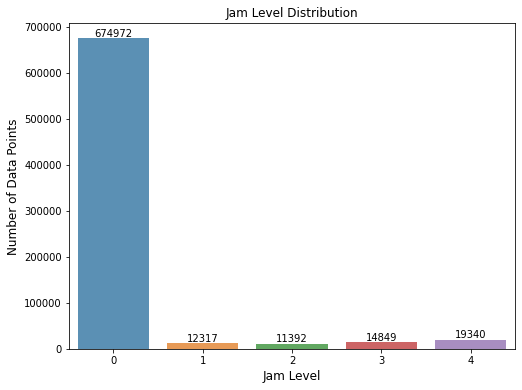

In [69]:
# Get the distribution of the number cases of different jamLevel
x = df_eda['jamLevel'].value_counts()
x = x.sort_index()

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Jam Level Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('Jam Level', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### TimeLine for DataSet

In [70]:
timeline = df_eda.groupby('time').count().reset_index()
timeline = timeline.sort_values('time', ascending = True)

#### TimeFrame for Dataset

It can be seen from the timeline of the overall data that after completing the data. Our data set is relatively uniform in time distribution.

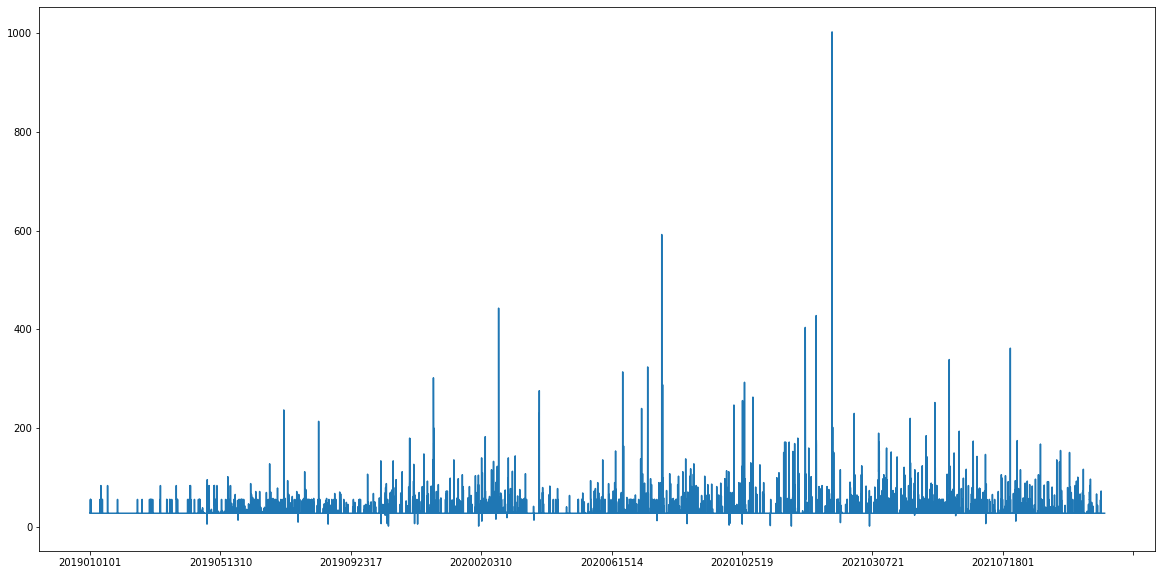

In [71]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

x = timeline['time']
y = timeline['street']

tick_spacing = 3000

fig, ax = plt.subplots(1,1, figsize = (20,10))

ax.plot(x,y)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.show()

#### dayTimeInterval
- earlyMorning = range(4, 8)
- Morning = range(8, 12)
- Noon = range(12, 14)
- AfterNoon = range(14, 19)
- Night = range(19, 24)
- MidNight = range(24, 4)

In [72]:
df_jam_eda = df_eda[df_eda['jamLevel'] > 0]

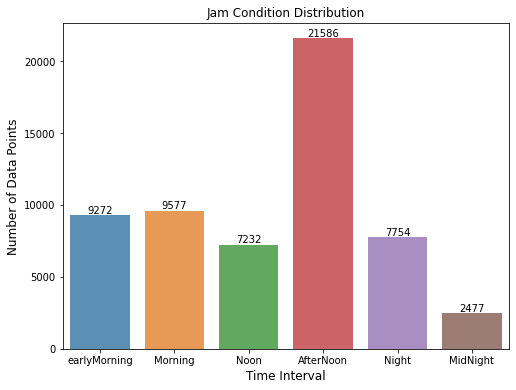

In [73]:
x = df_jam_eda['dayTimeInterval'].value_counts()
order = ['earlyMorning', 'Morning', 'Noon', 'AfterNoon', 'Night', 'MidNight']
x = x[order]

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Jam Condition Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('Time Interval', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### Hourly Jam Condition

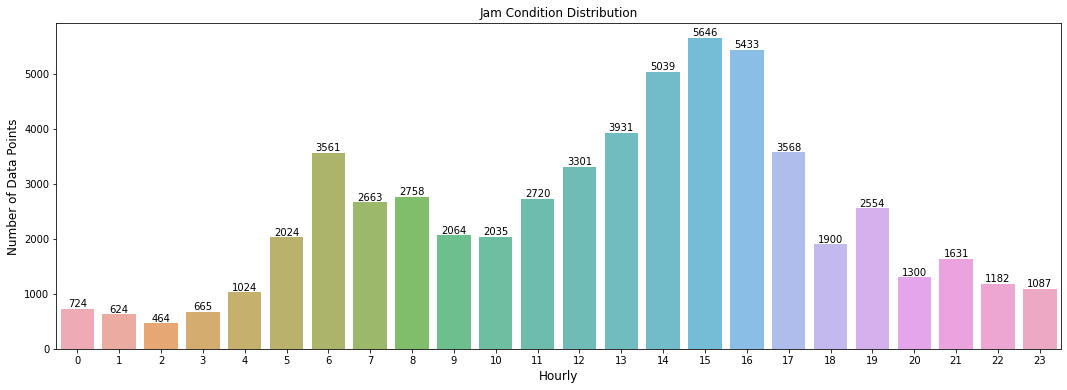

In [74]:
x = df_jam_eda['HourTime'].value_counts()
x = x.sort_index()

# plot
plt.figure(figsize=(18,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Jam Condition Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('Hourly', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# convert from UTC to local time 

In [75]:
df_eda_jam4 = df_eda[df_eda['jamLevel'] == 4]

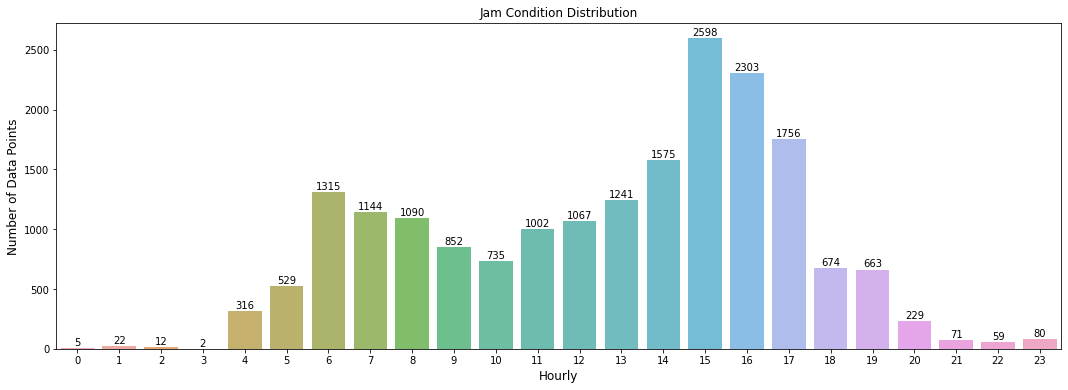

In [76]:
x = df_eda_jam4['HourTime'].value_counts()
x = x.sort_index()

# plot
plt.figure(figsize=(18,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Jam Condition Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('Hourly', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### WeekDay

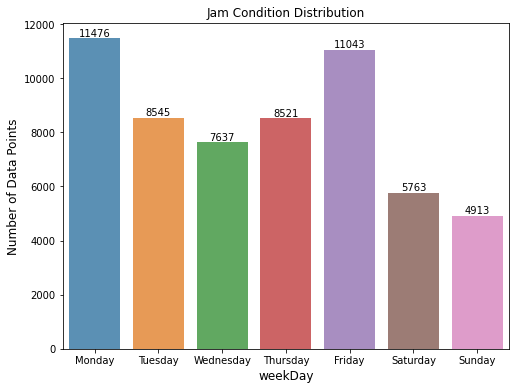

In [77]:
x = df_jam_eda['weekDay'].value_counts()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x = x[order]
# print(type(x))

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Jam Condition Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('weekDay', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### Season

In [78]:
print('the time period from:', np.min(df_jam_eda['time']) ,'to', np.max(df_jam_eda['time']))
df_jam_eda['time'] = df_jam_eda['time'].astype(int)
## df_jam_eda

the time period from: 2019042206 to 2021102606


In [79]:
df_jam_eda_2019 = df_jam_eda[df_jam_eda['time'] < 2020010100]
df_jam_eda_2020 = df_jam_eda[df_jam_eda['time'] > 2020010100]
df_jam_eda_2020 = df_jam_eda_2020[df_jam_eda_2020['time'] < 2021010100]
df_jam_eda_2021 = df_jam_eda[df_jam_eda['time'] > 2021010100]

In [80]:
print('the time period for df_jam_eda_2019 from:', np.min(df_jam_eda_2019['time']) ,'to', np.max(df_jam_eda_2019['time']))
print('the time period for df_jam_eda_2020 from:', np.min(df_jam_eda_2020['time']) ,'to', np.max(df_jam_eda_2020['time']))
print('the time period for df_jam_eda_2021 from:', np.min(df_jam_eda_2021['time']) ,'to', np.max(df_jam_eda_2021['time']))

the time period for df_jam_eda_2019 from: 2019042206 to 2019122917
the time period for df_jam_eda_2020 from: 2020010214 to 2020123017
the time period for df_jam_eda_2021 from: 2021010208 to 2021102606


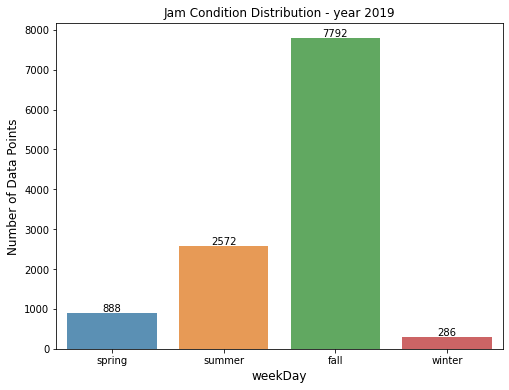

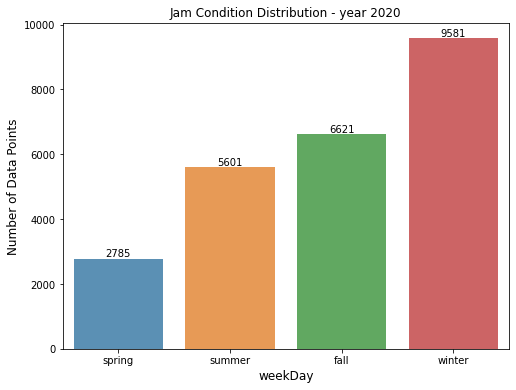

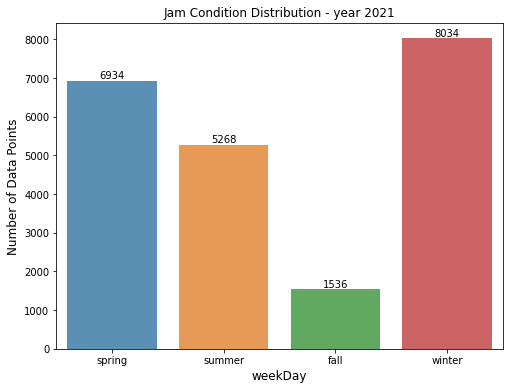

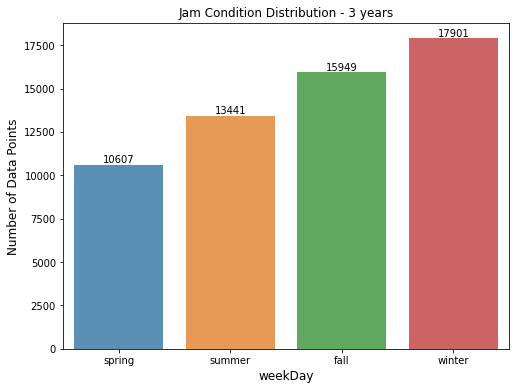

In [81]:
# year - 2019

x = df_jam_eda_2019['season'].value_counts()
order = ['spring', 'summer', 'fall', 'winter']
x = x[order]

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Jam Condition Distribution - year 2019")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('weekDay', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# year - 2020

x = df_jam_eda_2020['season'].value_counts()
order = ['spring', 'summer', 'fall', 'winter']
x = x[order]

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Jam Condition Distribution - year 2020")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('weekDay', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# year - 2021

x = df_jam_eda_2021['season'].value_counts()
order = ['spring', 'summer', 'fall', 'winter']
x = x[order]

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Jam Condition Distribution - year 2021")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('weekDay', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# year - total

x = df_jam_eda['season'].value_counts()
order = ['spring', 'summer', 'fall', 'winter']
x = x[order]

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Jam Condition Distribution - 3 years")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('weekDay', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Regular Speed - Jam Level

In [82]:
df_eda.groupby('jamLevel')['regularSpeed'].mean()

jamLevel
0     56.332281
1    114.662057
2    105.264721
3     96.666983
4     97.117076
Name: regularSpeed, dtype: float64

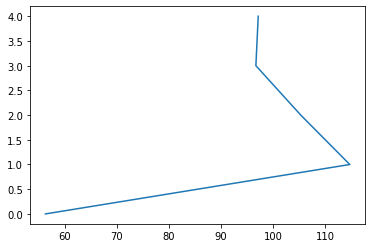

In [83]:
x = df_eda.groupby('jamLevel')['regularSpeed'].mean()
y = [0, 1, 2, 3, 4]

plt.plot(x, y)

### Correlation: Weather - Jam Level

In [84]:
data_jamDummy = pd.get_dummies(df_eda["jamLevel"])
df_eda_jamDummy  = df_eda.join(data_jamDummy)

In [85]:
df_eda_jamDummy.head(5)

,street,regularSpeed,time,jamLevel,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,dayTimeInterval,HourTime,season,weekDay,NextJamLevel,0,1,2,3,4
0,to SH-115 N,66.92,2019010101,0,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday,0,1,0,0,0,0
0,to SH-115 N,66.92,2019010101,0,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday,0,1,0,0,0,0
0,to SH-115 N,66.92,2019010101,0,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday,0,1,0,0,0,0
0,to SH-115 N,66.92,2019010101,0,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday,0,1,0,0,0,0
0,to SH-115 N,66.92,2019010101,0,258.3,258.3,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday,0,1,0,0,0,0


In [86]:
### weather_combination 
rain_lst = ['Drizzle', 'Rain', 'Thunderstorm']
fog_lst = ['Fog', 'Haze', 'Mist', 'Smoke']

def weather_com(weather_name):
  if weather_name in rain_lst:
    return 'Rain Condition'
  elif weather_name in fog_lst:
    return 'Fog Condition'
  else:
    return weather_name

In [87]:
df_eda_jamDummy['Weatcher_Combine'] = df_eda_jamDummy['weather_main'].apply(lambda x: weather_com(x))

In [88]:
# df_eda_jamDummy
def if_jam(x):
  if x > 0:
    return 1 
  else:
    return 0 

In [89]:
df_eda_jamDummy['ifJam'] = df_eda_jamDummy['jamLevel'].apply(lambda x: if_jam(x))

In [90]:
# df_eda_jamDummy.columns.tolist()
func = lambda x: 100*x.count()/df.shape[0]

In [91]:
df_eda_jamDummy.columns = [             'street',        'regularSpeed',                'time',
                  'jamLevel',                'temp',          'feels_like',
                  'temp_min',            'temp_max',            'pressure',
                  'humidity',          'wind_speed',            'wind_deg',
                'clouds_all',          'weather_id',        'weather_main',
       'weather_description',        'weather_icon',     'dayTimeInterval',
                  'HourTime',              'season',             'weekDay',
              'NextJamLevel',                     'No_Jam',                     1,
                           2,                     3,                     4,
          'Weather',               'Traffic_Jam']

In [92]:
pd.pivot_table(df_eda_jamDummy,index=['Weather'], values=['No_Jam', 'Traffic_Jam'], aggfunc= ['sum'])

sum            
                   No_Jam Traffic_Jam
Weather                              
Clear           5960175.0      215658
Clouds          7275125.0      219665
Dust               1538.0           0
Fog Condition   1214536.0      114346
Rain Condition  1955064.0      149700
Snow            1273966.0      240850
Squall            15540.0        1395

In [93]:
df_pivot_weather = pd.pivot_table(df_eda_jamDummy,index=['Weather'], values=['No_Jam', 'Traffic_Jam'], aggfunc= ['sum'])
df_pivot_weather.columns = df_pivot_weather.columns.droplevel(0)
df_pivot_weather = df_pivot_weather.reset_index()

In [94]:
df_pivot_weather.set_index(["Weather"], inplace=True)
# df_pivot_weather

In [95]:
df_pivot_weather = df_pivot_weather.div(df_pivot_weather.sum(axis=1), axis=0)
df_pivot_weather = df_pivot_weather.sort_values(by = 'Traffic_Jam', ascending = False)

In [96]:
data = df_pivot_weather.copy()
data['No_Jam'] = data['No_Jam'].apply(lambda x: '%.0f%%' % (x*100))
data['Traffic_Jam'] = data['Traffic_Jam'].apply(lambda x: '%.0f%%' % (x*100))                                                  

In [97]:
data

,No_Jam,Traffic_Jam
Weather,,
Snow,84%,16%
Fog Condition,91%,9%
Squall,92%,8%
Rain Condition,93%,7%
Clear,97%,3%
Clouds,97%,3%
Dust,100%,0%


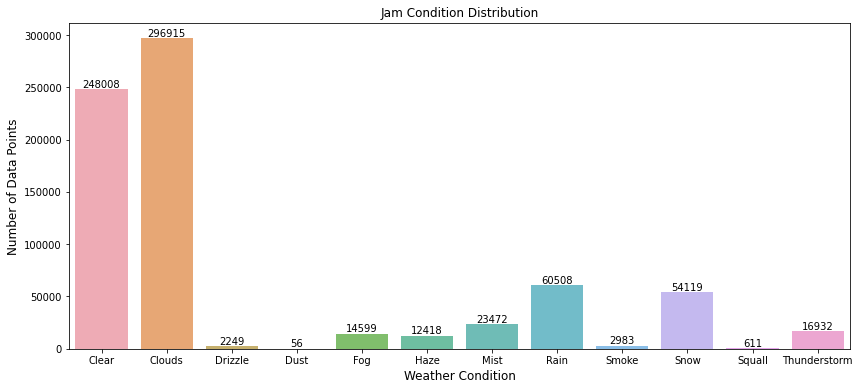

In [98]:
x = df_eda['weather_main'].value_counts()
x = x.sort_index()

# plot
plt.figure(figsize=(14,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Jam Condition Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('Weather Condition', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## HeatMap

In [99]:
table = pd.pivot_table(df_jam_eda,index=['HourTime'],columns=['weekDay'],values=['jamLevel'],aggfunc=['count'],fill_value=0)

In [100]:
table.columns = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
table = table[order]

In [101]:
table

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
HourTime,,,,,,,
0,170,292,22,59,161,20,0
1,231,146,5,28,136,8,70
2,183,116,15,15,115,0,20
3,155,110,12,0,246,4,138
4,270,260,66,199,168,3,58
5,546,607,159,152,435,13,112
6,964,793,600,453,673,12,66
7,584,627,372,316,655,13,96
8,430,422,735,286,436,302,147


### HeatMap - All Jam Level across a week

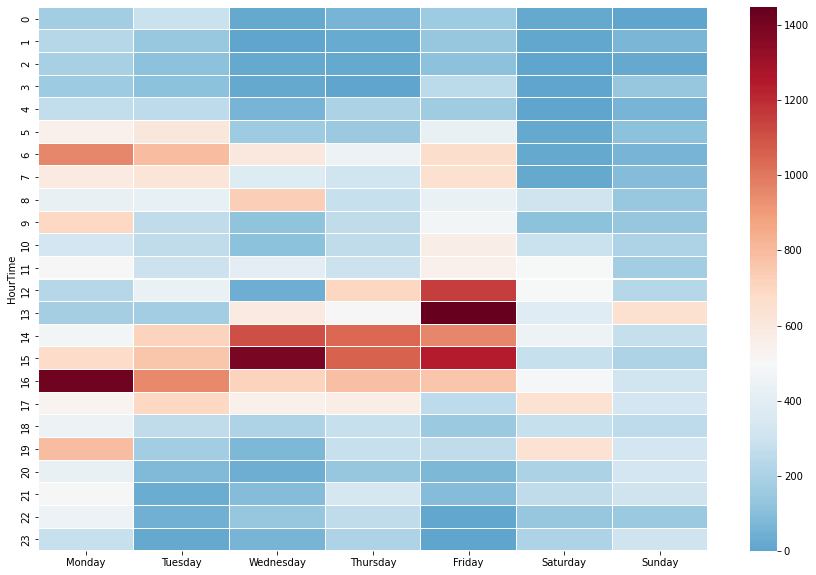

In [102]:
sns.set_context({"figure.figsize":(15,10)})
sns.heatmap(data=table, cmap="RdBu_r", linewidths=0.1, center = 500) 

In [103]:
# table_only_4_level
table4 = pd.pivot_table(df_eda_jam4,index=['HourTime'],columns=['weekDay'],values=['jamLevel'],aggfunc=['count'],fill_value=0)

### HeatMap - Highest Jam Level across a week

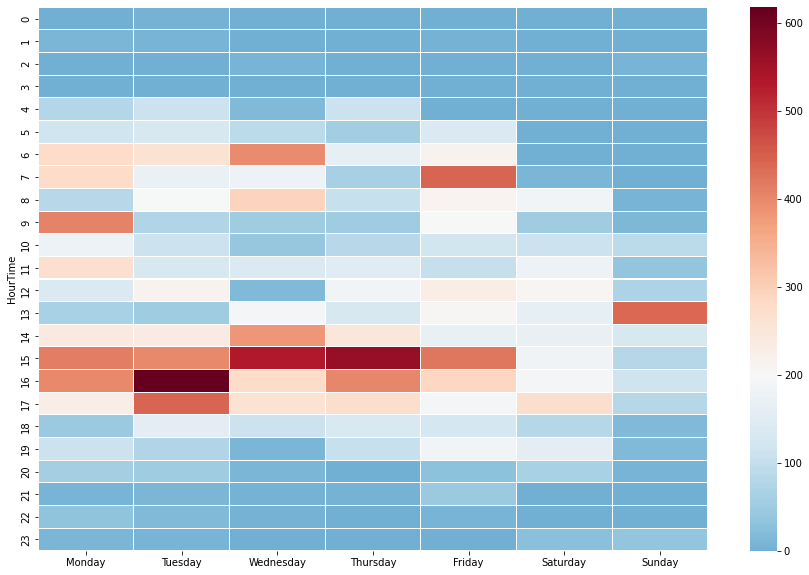

In [104]:
table4.columns = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
table4 = table4[order]

sns.set_context({"figure.figsize":(15,10)})
sns.heatmap(data=table4, cmap="RdBu_r", linewidths=0.1, center = 200) 

### HeatMap - Jam Level with other features

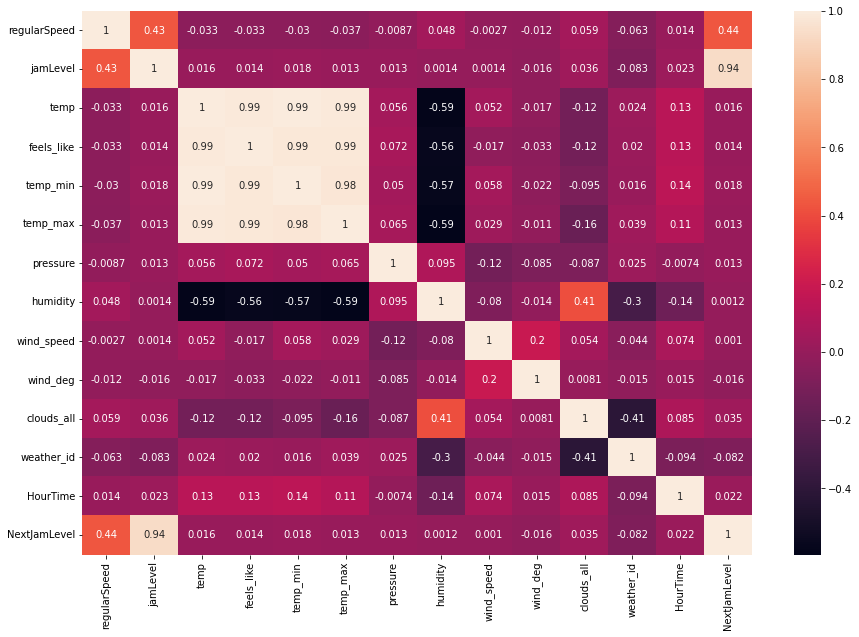

In [105]:
# heatmap 
plt.figure(figsize=(15, 10))

sns.heatmap(df_eda.corr(), annot=True)

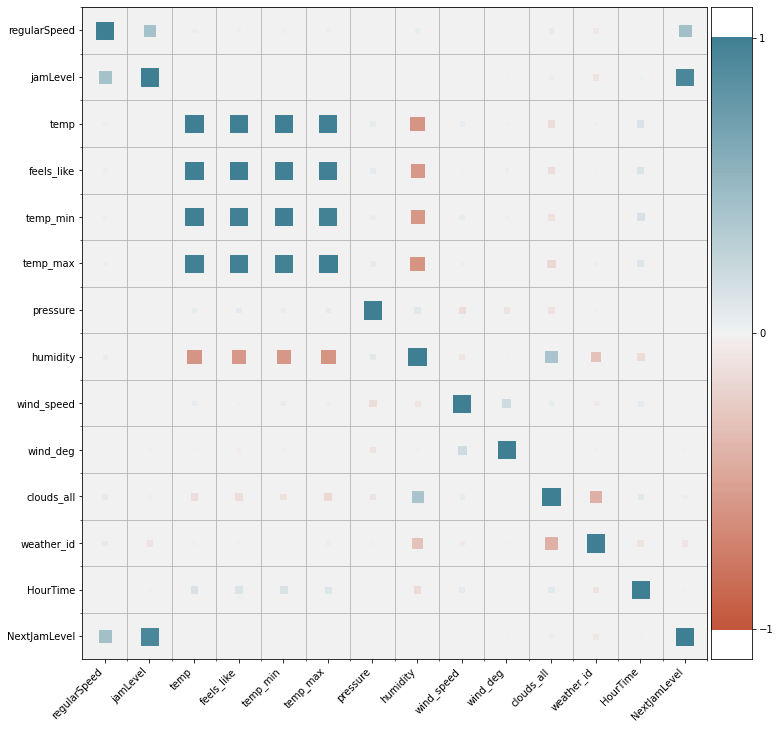

In [106]:
# !pip install heatmapz
from heatmap import heatmap, corrplot

data = df_eda
plt.figure(figsize=(12, 12))
corrplot(data.corr(), size_scale=300)

### HeatMap - Jam Level and Weather

In [107]:
# df_eda

In [108]:
df_tmp_wea1 = df_eda[['weather_main', 'jamLevel']]
# df_tmp_wea1['Weatcher_Combine'] = df_tmp_wea1['weather_main'].apply(lambda x: weather_com(x))
df_eda_wea_dummy = pd.get_dummies(df_tmp_wea1["weather_main"])
df_eda_wea_dummy['jamLevel'] = df_eda['jamLevel']

In [109]:
# df_tmp_wea1

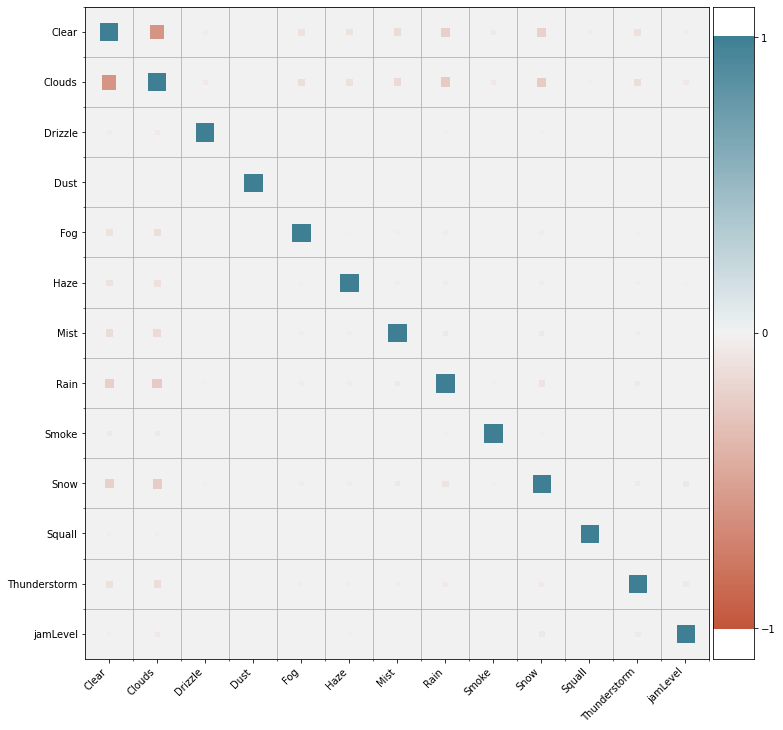

In [110]:
data = df_eda_wea_dummy
plt.figure(figsize=(12, 12))
corrplot(data.corr(), size_scale=300)

By default, we use the Pearson correlation coefficient to calculate the correlation.

In [111]:
df_cor = df_eda.corr()
df_cor['jamLevel']

regularSpeed    0.434422
jamLevel        1.000000
temp            0.016120
feels_like      0.014002
temp_min        0.018064
temp_max        0.012595
pressure        0.013030
humidity        0.001351
wind_speed      0.001422
wind_deg       -0.015832
clouds_all      0.035864
weather_id     -0.082746
HourTime        0.023366
NextJamLevel    0.936405
Name: jamLevel, dtype: float64

In [112]:
df_tmp_wea_detail = df_eda[['weather_description', 'jamLevel']]
# df_tmp_wea1['Weatcher_Combine'] = df_tmp_wea1['weather_main'].apply(lambda x: weather_com(x))
df_eda_wea_detail_dummy = pd.get_dummies(df_tmp_wea_detail["weather_description"])
df_eda_wea_detail_dummy['jamLevel'] = df_tmp_wea_detail['jamLevel']

In [113]:
df_cor = df_eda_wea_detail_dummy.corr()
# df_cor['jamLevel'].abs()

In [114]:
df_cor['jamLevel_abs'] = df_cor['jamLevel'].abs()
df_cor.sort_values(by = 'jamLevel_abs', ascending = False)['jamLevel']

jamLevel                        1.000000
snow                            0.071146
thunderstorm                    0.060106
broken clouds                  -0.036213
light snow                      0.033876
sky is clear                   -0.026877
moderate rain                   0.026355
overcast clouds                -0.026238
heavy snow                      0.024487
haze                            0.021761
scattered clouds               -0.020656
mist                            0.017812
fog                             0.016807
shower rain                     0.013121
thunderstorm with light rain    0.011068
heavy shower snow               0.008988
proximity thunderstorm          0.006687
light intensity shower rain     0.004799
few clouds                     -0.004543
light intensity drizzle        -0.004431
thunderstorm with heavy rain    0.004302
squalls                         0.003973
heavy intensity rain           -0.003814
thunderstorm with rain         -0.003708
light shower sle

In [115]:
data_corr = df_cor.sort_values(by = 'jamLevel_abs', ascending = False)['jamLevel']

In [118]:
len(data_corr)

37

## Model

In [116]:
df_eda.columns

Index(['street', 'regularSpeed', 'time', 'jamLevel', 'temp', 'feels_like',
       'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'clouds_all', 'weather_id', 'weather_main',
       'weather_description', 'weather_icon', 'dayTimeInterval', 'HourTime',
       'season', 'weekDay', 'NextJamLevel'],
      dtype='object')

In [117]:
# check the unique value 
df_model = df_eda.copy()
df_model = df_model.drop(columns = 'time')
df_model['weather_description'].unique()

array(['overcast clouds', 'light snow', 'mist', 'fog', 'scattered clouds',
       'sky is clear', 'few clouds', 'snow', 'light rain',
       'broken clouds', 'squalls', 'light intensity drizzle',
       'moderate rain', 'light intensity shower rain',
       'light shower snow', 'shower rain', 'heavy snow', 'haze',
       'light shower sleet', 'heavy intensity drizzle', 'shower snow',
       'heavy intensity rain', 'thunderstorm', 'proximity thunderstorm',
       'thunderstorm with light rain', 'shower sleet', 'sleet',
       'very heavy rain', 'heavy intensity shower rain',
       'thunderstorm with rain', 'thunderstorm with heavy rain', 'smoke',
       'drizzle', 'dust', 'heavy shower snow', 'light rain and snow'],
      dtype=object)

In [118]:
df_model_1 = df_model.copy()

#### VIF Checking

In the entire process of Feature Engineering, there are mainly three steps. They are VIF checking, Encoding and Rescalling. The purpose is to better process the variables that the model can learn.

VIF Checking

When performing linear regression analysis, it is easy to appear that the independent variables (explanatory variables) are related to each other. We call this phenomenon multicollinearity.

Moderate multicollinearity is not a problem, but when serious collinearity occurs, the analysis result will be unstable, and the sign of the regression coefficient will be completely opposite to the actual situation. The independent variable that should be significant is not significant, but the insignificant independent variable is significant. In this case, it is necessary to eliminate the effect of multicollinearity.

The so-called VIF method is not difficult to calculate. Among the linear regression methods, the most widely used method is the least squares method (OLS), but for each factor, we use the other N factors for regression interpretation. One of the statistical indicators for testing the explanatory power of the model is R^2 (the coefficient of determination of the sample). The size of R^2 determines the explanatory power of the explanatory variable to the dependent variable. In order to test the linear correlation between factors, we can use OLS to regress a single factor and an explanatory factor, and then if its R^2 is small, it means that this factor is less explained by other factors, and the linear correlation is low.

　　Note: The reason why the covariance is not used to calculate the correlation is because the covariance is difficult to apply in the case of multiple linear correlation. Give the VIF calculation method:

                      VIF = 1 / (1-R^2)

It is easy to see from the above that the higher the VIF, the stronger the linear correlation between the explanatory variable and the dependent variable. The method of using VIF to test is mainly to regress a certain factor and other factors to obtain R^2, calculate VIF, remove the factor with high VIF, keep the factor with lower VIF, and so on, until a correlation is obtained Combinations of low-performing factors can enhance the explanatory power of the model.


In [119]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

cols = ['regularSpeed', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure',
        'humidity','wind_speed','wind_deg','clouds_all','weather_id','HourTime'] 

df_vif = df_model_1.copy()
def vif_check(data, col):
    data = data.loc[:, col] 
    vif = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])][1:] 
    return col, vif

vif_dataframe = pd.DataFrame(vif_check(df_vif, cols))

In [120]:
vif_dataframe

,0,1,2,3,4,5,6,7,8,9,10,11
0,regularSpeed,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,HourTime
1,249792,82417.9,66714.8,49860.6,1579.48,13.4432,3.16138,3.65978,3.34581,45.3664,4.78092,None


In [121]:
### Some of columns are highly correlated, we need to delete these columns
df_model_vif = df_model_1.drop(columns = ['temp_min', 'temp_max','feels_like'])

In [122]:
cols = ['regularSpeed', 'temp', 'pressure',
        'humidity','wind_speed','wind_deg','clouds_all','weather_id','HourTime'] 

vif_dataframe = pd.DataFrame(vif_check(df_model_vif, cols))

vif_dataframe

,0,1,2,3,4,5,6,7,8
0,regularSpeed,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,HourTime
1,1092.92,1367.47,12.8517,2.0112,3.62423,3.14714,45.228,4.70552,None


As code above, we have detected considerable multicollinearity between temperatures through VIF detection, so we have removed three related variables. In addition, we still retain some variables with larger VIF values. This is also to ensure the effect of our model. Usually we think:

1. Multicollinearity is common. If the VIF value is greater than 10, it means that the collinearity is very serious. This situation needs to be dealt with. If the VIF value is below 5, there is no need to deal with it. Between 5~10 depending on the situation.

2. If the model is only used for prediction, as long as the fit is good, the problem of multicollinearity may not be dealt with. When a model with multicollinearity is used for prediction, it often does not affect the prediction results.


#### Label_Encoder

​​In Encoding, we mainly adopt two methods. One is Label Encoder, and the other is Target Encoder.

Label encoding is to assign a value to each category in the category variable, thereby converting it into a numeric value. For example, there is a column [dog,cat,dog,mouse,cat], we convert it to [1,2,1,3,2]. Here is a strange phenomenon: the average value of dog and mouse is cat, so the most intuitive disadvantage of label encoding is that the assignment is difficult to explain and the applicable scenarios are narrower.

The advantage of one hot encoding is that its value is only 0/1, and different types are stored in a vertical space. The disadvantage is that when the number of categories is large, the feature space becomes very large. But in actual use, because one hot encoding increases the dimensionality of the variables, it means deeper splits in the tree model. If the depth of the tree is limited to a value, the dog category may not be included in the model, which actually means that it is lost The dog information, and the second label encoding above does not have this problem, which also means that the fitting effect will be better.

So in this case, we performed Label Encoding for most of the variables (variables that easily produce high-latitude features).


In [123]:
le = LabelEncoder()

loc_lst = df_model_1['street'].unique().tolist()
le.fit(df_model_1['street'])
df_model_1['street_encode'] = le.transform(df_model_1['street'])

loc_lst = df_model_1['weather_icon'].unique().tolist()
le.fit(df_model_1['weather_icon'])
df_model_1['weather_icon_encode'] = le.transform(df_model_1['weather_icon'])

loc_lst = df_model_1['weekDay'].unique().tolist()
le.fit(df_model_1['weekDay'])
df_model_1['weekDay_encode'] = le.transform(df_model_1['weekDay'])

loc_lst = df_model_1['weather_description'].unique().tolist()
le.fit(df_model_1['weather_description'])
df_model_1['weather_description_encode'] = le.transform(df_model_1['weather_description'])

loc_lst = df_model_1['season'].unique().tolist()
le.fit(df_model_1['season'])
df_model_1['season_encode'] = le.transform(df_model_1['season'])

loc_lst = df_model_1['dayTimeInterval'].unique().tolist()
le.fit(df_model_1['dayTimeInterval'])
df_model_1['dayTimeIntervaln_encode'] = le.transform(df_model_1['dayTimeInterval'])

#### Target_Encoder

Feature encoding can be performed only based on the feature itself, or it can be performed in conjunction with target information. Target encoding is a way of feature encoding combined with target values. Formally speaking, target encoding is to replace the feature value with a given feature value, and the target value is a mixture of the prior probability and the posterior probability of the target value in the training data.

In [125]:
df_model_1

,street,regularSpeed,jamLevel,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,dayTimeInterval,HourTime,season,weekDay,NextJamLevel,street_encode,weather_icon_encode,weekDay_encode,weather_description_encode,season_encode,dayTimeIntervaln_encode
0,to SH-115 N,66.920000,0,258.30,258.30,256.38,260.33,1022.0,73.0,0.89,43.0,90.0,804.0,Clouds,overcast clouds,04n,MidNight,1,winter,Tuesday,0,26,7,5,20,3,1
1,to SH-115 N,66.920000,0,258.31,254.88,256.87,260.33,1023.0,75.0,1.34,43.0,90.0,600.0,Snow,light snow,13n,MidNight,2,winter,Tuesday,0,26,15,5,17,3,1
2,to SH-115 N,66.920000,0,258.29,254.85,257.23,259.77,1022.0,77.0,1.34,43.0,90.0,600.0,Snow,light snow,13n,MidNight,3,winter,Tuesday,0,26,15,5,17,3,1
3,to SH-115 N,66.920000,0,258.27,258.27,257.23,259.21,1022.0,79.0,0.00,0.0,90.0,600.0,Snow,light snow,13n,earlyMorning,4,winter,Tuesday,0,26,15,5,17,3,5
4,to SH-115 N,66.920000,0,258.20,258.20,257.23,259.06,1021.0,79.0,0.00,0.0,75.0,600.0,Snow,light snow,13n,earlyMorning,5,winter,Tuesday,0,26,15,5,17,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27800,S Academy Blvd,62.133654,0,291.65,290.29,290.22,293.50,1022.0,28.0,1.34,189.0,1.0,800.0,Clear,sky is clear,01d,Noon,12,fall,Friday,0,17,0,0,26,0,4
27801,S Academy Blvd,62.133654,0,292.22,290.89,289.91,294.61,1020.0,27.0,1.34,114.0,1.0,800.0,Clear,sky is clear,01d,Noon,13,fall,Friday,0,17,0,0,26,0,4
27802,S Academy Blvd,62.133654,0,292.25,290.89,289.91,294.95,1020.0,26.0,0.89,124.0,1.0,800.0,Clear,sky is clear,01d,AfterNoon,14,fall,Friday,0,17,0,0,26,0,0
27803,S Academy Blvd,62.133654,0,291.34,289.89,288.70,294.39,1019.0,26.0,0.89,148.0,1.0,800.0,Clear,sky is clear,01d,AfterNoon,15,fall,Friday,0,17,0,0,26,0,0


In [126]:
import category_encoders as ce

encoder = ce.TargetEncoder(cols='weather_main')
df_model_1['weather_target'] = encoder.fit_transform(df_model_1['weather_main'],df_model_1['NextJamLevel'])

In [127]:
encoder = ce.TargetEncoder(cols='weather_description')
df_model_1['weather_desc_target'] = encoder.fit_transform(df_model_1['weather_description'],df_model_1['NextJamLevel'])

In [128]:
len(df_model_1)

732870

#### One-Hot

We can still choose the one-hot method, if they want to use this encoding method in subsequent teams.

In [129]:
# # ### one-hot 
# df_onehot = pd.get_dummies(df_model_1['weather_description'], prefix='oneHot') 
# # df_model_2 = pd.concat([df_onehot[])
# df_model_2 = pd.concat([df_onehot, df_model_1], axis=1)


In [130]:
# df_model_2

In [131]:
df_model_2 = df_model_1.copy()

In [132]:
df_model_3 = df_model_2.drop(columns = ['street', 'weather_main', 'weather_description', 'temp_min', 'temp_max','feels_like',
                                        'weather_icon','season','weekDay', 'dayTimeInterval', 'temp_min', 'temp_max'
                                        ,'weather_id'])

In [133]:
### ready for model 

In [134]:
df_model_3.columns

Index(['regularSpeed', 'jamLevel', 'temp', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds_all', 'HourTime', 'NextJamLevel',
       'street_encode', 'weather_icon_encode', 'weekDay_encode',
       'weather_description_encode', 'season_encode',
       'dayTimeIntervaln_encode', 'weather_target', 'weather_desc_target'],
      dtype='object')

In [135]:
len(df_model_3.columns)

18

#### Rescaling (Z-Score normalization)

Feature Scaling is a method of standardizing the orientation of different variables or features of data. It is more commonly used in data processing and is also called Data Normalization. The purpose is mainly to cancel the errors caused by the different dimensions, which are all linear changes, and they are all compressed in proportion to the vector x for translation. There are two main functions:

Data co-chemotaxis processing: Turn the data into decimals in a fixed interval (0,1) or (-1,1), and map the data to a fixed range for processing, which is more convenient and faster;
Dimensionless processing: change the dimensional expression into a dimensionless expression, which is convenient for comparing and weighting the parameters of different units or magnitudes.

Here we use the Z-score normalization method (Z-score Normalization), which is based on the homogenous X_mean and standard deviation X_std of the original data X of the attribute A to standardize the data, which is suitable for the maximum value X_Max and X_Max of the attribute A The case where the minimum value X_Min is unknown, or there is outlier data that exceeds the value range.



In [136]:
from sklearn import preprocessing
cols = ['regularSpeed', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all']

z_scaler= preprocessing.StandardScaler()

df = df_model_3
for item in cols:
  df[item] = z_scaler.fit_transform(np.array(df[item]).reshape(-1, 1))

In [137]:
df

,regularSpeed,jamLevel,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,HourTime,NextJamLevel,street_encode,weather_icon_encode,weekDay_encode,weather_description_encode,season_encode,dayTimeIntervaln_encode,weather_target,weather_desc_target
0,0.284454,0,-2.313024,0.696093,0.891624,-0.404654,-1.187749,1.359196,1,0,26,7,5,20,3,1,0.162730,0.111350
1,0.284454,0,-2.312116,0.847607,0.978152,-0.129421,-1.187749,1.359196,2,0,26,15,5,17,3,1,0.408341,0.343604
2,0.284454,0,-2.313932,0.696093,1.064681,-0.129421,-1.187749,1.359196,3,0,26,15,5,17,3,1,0.408341,0.343604
3,0.284454,0,-2.315748,0.696093,1.151209,-0.949003,-1.577530,1.359196,4,0,26,15,5,17,3,5,0.408341,0.343604
4,0.284454,0,-2.322105,0.544578,1.151209,-0.949003,-1.577530,0.945995,5,0,26,15,5,17,3,5,0.408341,0.343604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27800,0.088647,0,0.715603,0.696093,-1.055268,-0.129421,0.135696,-1.092465,12,0,17,0,0,26,0,4,0.184309,0.184309
27801,0.088647,0,0.767366,0.393063,-1.098532,-0.129421,-0.544156,-1.092465,13,0,17,0,0,26,0,4,0.184309,0.184309
27802,0.088647,0,0.770091,0.393063,-1.141796,-0.404654,-0.453509,-1.092465,14,0,17,0,0,26,0,0,0.184309,0.184309
27803,0.088647,0,0.687451,0.241548,-1.141796,-0.404654,-0.235957,-1.092465,15,0,17,0,0,26,0,0,0.184309,0.184309


#### Future Suggestion for Feature Engineering 

As we discussed above, there are many different methods for Encoding and feature scaling. In the subsequent model expansion, we propose the following suggestions, focusing on the directions that can be tried in the Feature Engineering section:

1. Adopt other more effective encoding methods. Both target encoding and label encoding essentially introduce Y_label information in advance, which may lead to overfitting problems. For the over-fitting problem of Target Encoding, we can solve it through cross validation. Used in conjunction with Target Beta Encoding.

2. Use other scaling methods, such as Min-Max normalization.

3. Take feature intersection to construct more features. Here at the end we actually only used eighteen variables as our features, which is far from enough for complex predictions. We can adopt feature intersection methods (for example, using feature tools API) to construct more new features to further improve the accuracy of the model.


In [138]:
train_col_df = df.drop(columns = ['NextJamLevel'])

# Set the train input and train output 

trainInput = train_col_df
trainOutput = df['NextJamLevel']

In [139]:
# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(trainInput, trainOutput, test_size=0.2, random_state=0)

#### DecisionTree

In [140]:
# DecisionTree Model
DT = DecisionTreeClassifier(random_state=1, criterion="gini", max_depth = 20)
DT.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=20, random_state=1)

In [141]:
acu_test = DT.score(X_test, y_test)
acu_train = DT.score(X_train, y_train)

In [142]:
print(acu_train)

0.98670978481859


#### Random Forest

In [143]:
# RandomForest Model
RF = RandomForestClassifier()
RF.fit(X_train,y_train)

# predict the results
y_pred = RF.predict(X_test)

# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('RandomForest Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

RandomForest Model accuracy score: 0.9722


In [144]:
print('Training set score: {:.4f}'.format(RF.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(RF.score(X_test, y_test)))

Training set score: 0.9916
Test set score: 0.9722


In [145]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    134810
           1       0.78      0.78      0.78      2499
           2       0.57      0.54      0.55      2278
           3       0.58      0.56      0.57      3000
           4       0.77      0.77      0.77      3987

    accuracy                           0.97    146574
   macro avg       0.74      0.73      0.74    146574
weighted avg       0.97      0.97      0.97    146574



#### Lightgbm

 We tried many different models, decision tree, KNN, random forest and LightGBM. Among them, we found that with the default parameters, LightGBM performed better than other models.

At the beginning, we tried a variety of models with a small sample data set, and found that the highest AUC was LightGBM. But it is worth noting that because we are facing an unbalanced sample, we need to look at the specific indicators of each category in the case of multi-classification.

Among them, the comprehensive index used to select the model is Macro Average. Macro Average will first calculate the evaluation indicators such as Precision, Recall, F1 Score for each category, and then average them to get Macro Precision, Macro Recall, Macro F1. This indicator will take into account the contributions of all categories and is suitable for evaluating the effect of the model in the case of multiple classifications. Through the comparison of Figure 20 and Figure 21, we can find that the effect of LightGBM is slightly better than Random Forest, which is mainly reflected in the classification of categories 1 and 2.



In [146]:
import lightgbm as lgb

### lgbm
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [147]:
# predict the results
y_pred = lgbm.predict(X_test)

In [148]:
# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9722


In [149]:
print('Training set score: {:.4f}'.format(lgbm.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(lgbm.score(X_test, y_test)))

Training set score: 0.9745
Test set score: 0.9722


In [150]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [151]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    134810
           1       0.82      0.79      0.80      2499
           2       0.61      0.52      0.56      2278
           3       0.56      0.60      0.58      3000
           4       0.73      0.79      0.76      3987

    accuracy                           0.97    146574
   macro avg       0.74      0.74      0.74    146574
weighted avg       0.97      0.97      0.97    146574



#### Feature Importance 

The Feature Importance here shows which features help us better predict blockages, for example In this picture, temperature and regular speed of the road are actually the two most useful information. The interpretation here also provides some direction for future model expands. It tells us that historical and current traffic information will be very helpful to model predictions.


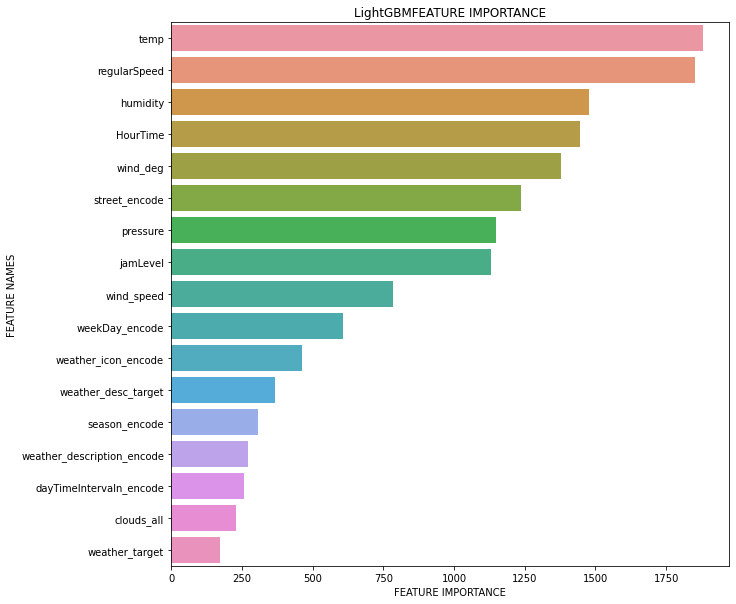

In [152]:
def plot_feature_importance(importance,names,model_type):
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,10))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance(lgbm.feature_importances_,X_train.columns,'LightGBM')

#### Tunning Model - HyperOpt

In [ ]:
from sklearn.model_selection import cross_validate
def eval_model(params, X_train, y_train):
  model = lgb.LGBMClassifier(**params)
  cv_lgb_results = cross_validate(model, X_train, y_train, cv = 3, scoring='roc_auc_ovr')
  res = np.mean(cv_lgb_results['test_score'])
  print(res)
  return 1 - res

In [ ]:
from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

In [ ]:
space = {
        # number of trees and learning rate -------------
        'n_estimators': ho_scope.int(hp.quniform('n_estimators',300,800,100)), # eval autotune
        'learning_rate': hp.loguniform('learning_rate',np.log(1e-5),np.log(0.05)), # eval autotune
        # tree depth ------------------------------------
        'max_depth':  ho_scope.int(hp.quniform('max_depth',30,80,10)),
        # 'num_leaves': hp.choice(label = 'num_leaves', options = [15, 31, 63, 127, 255, 511, 1023, 2047, 4095]),
        'min_child_weight':  ho_scope.int(hp.quniform('min_child_weight',0,X_train.shape[0]/100,1)),
        # conservative update step ----------------------
        ##'max_delta_step': ho_scope.int(hp.quniform('max_delta_step',1,10,1)),
        # sampling --------------------------------------
        'subsample': hp.uniform('subsample',0.4,1), 
        'colsample_bytree': hp.uniform('colsample_bytree',0.4,1),
        #'feature_fraction': hp.uniform('feature_fraction',0.2,0.7),
        # regularization --------------------------------
        'reg_lambda': hp.loguniform('reg_lambda',np.log(1e-4),np.log(10)),
        'reg_alpha': hp.loguniform('reg_alpha',np.log(1e-4),np.log(10)),
        'min_gain_to_split': hp.loguniform('min_gain_to_split',np.log(1e-4),np.log(2)),
        # specific lgbm ---------------------------------
        'min_child_samples': ho_scope.int(hp.quniform('min_child_samples',500,1500,200))}
        # set weights for balancing ---------------------
        # 'scale_pos_weight' : ho_scope.int(hp.loguniform('scale_pos_weight',np.log(1),np.log(scale_pos_weight_max)))
        

In [ ]:
from functools import partial
optimization = fmin(fn = partial(eval_model, X_train = X_train, y_train = y_train),
                  space = space, 
                  algo = tpe.suggest,
                  max_evals = 30, 
                  rstate = np.random.RandomState(42))

0.9753359330053258
0.975031963042677
0.9905341950790132
0.9849788254013024
0.9915516477367529
0.975265320373239
0.9896110904092404
0.9891624608586661
0.9896627716990899
0.9880912063297647
0.9898744147205577
0.988895619884851
0.9748352638889982
0.9869350878623958
0.9900936193267653
0.9901781114092657
0.9842429517013045
0.9220916590771108
0.9842011549862834
0.9760639159138815
0.9914570336956295
0.9913011572489118
0.9222832257715862
0.9905900888443684
0.9921819162411296
0.9917238263430862
0.9870676344211139
0.9918574718429399
0.9902823028319023
0.9898814920794856
100%|██████████| 30/30 [1:26:35<00:00, 173.19s/it, best loss: 0.007818083758870387]


In [ ]:
optimization

{'colsample_bytree': 0.6751966726310349,
 'learning_rate': 0.008737261877660378,
 'max_depth': 80.0,
 'min_child_samples': 1200.0,
 'min_child_weight': 14.0,
 'min_gain_to_split': 0.20606376549064742,
 'n_estimators': 600.0,
 'reg_alpha': 0.08301175114657587,
 'reg_lambda': 0.06157348900901955,
 'subsample': 0.8549620643957405}

#### Under-sampling

##### RUSBoostClassifier

In [ ]:
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(random_state=0)
rusboost.fit(X_train, y_train)

RUSBoostClassifier(random_state=0)

In [ ]:
# predict the results
y_pred = rusboost.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    134810
           1       0.56      0.50      0.53      2499
           2       0.42      0.27      0.33      2278
           3       0.47      0.42      0.44      3000
           4       0.35      0.56      0.43      3987

    accuracy                           0.93    146574
   macro avg       0.56      0.54      0.54    146574
weighted avg       0.93      0.93      0.93    146574



##### BalancedRandomForestClassifier

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier()

brf.fit(X_train, y_train)

BalancedRandomForestClassifier()

In [ ]:
# predict the results
y_pred = brf.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    134810
           1       0.66      0.79      0.72      2499
           2       0.48      0.60      0.53      2278
           3       0.52      0.58      0.55      3000
           4       0.79      0.74      0.76      3987

    accuracy                           0.97    146574
   macro avg       0.69      0.74      0.71    146574
weighted avg       0.97      0.97      0.97    146574



##### RandomUnderSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(sampling_strategy='majority', random_state = 1)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [ ]:
import lightgbm as lgb

### lgbm
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_res, y_res)

# predict the results
y_pred = lgbm.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    134810
           1       0.69      0.79      0.74      2499
           2       0.57      0.51      0.54      2278
           3       0.43      0.62      0.50      3000
           4       0.72      0.79      0.76      3987

    accuracy                           0.96    146574
   macro avg       0.68      0.74      0.71    146574
weighted avg       0.97      0.96      0.96    146574



#### Over-sampling - SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
len(X_train)

586296

In [ ]:
Smote_X_train = X_train[:400000]
Smote_y_train = y_train[:400000]

In [ ]:
# Check it again after SMOTE
smo = SMOTE()
X_smo, y_smo = smo.fit_resample(Smote_X_train, Smote_y_train)

print(Counter(y_smo))

Counter({4: 368704, 0: 368704, 2: 368704, 1: 368704, 3: 368704})


In [ ]:
import lightgbm as lgb

### lgbm
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_smo, y_smo)

# predict the results
y_pred = lgbm.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    134810
           1       0.81      0.78      0.79      2499
           2       0.57      0.56      0.57      2278
           3       0.57      0.59      0.58      3000
           4       0.76      0.77      0.76      3987

    accuracy                           0.97    146574
   macro avg       0.74      0.74      0.74    146574
weighted avg       0.97      0.97      0.97    146574



In [ ]:
X_train_5 = X_train[:100000]
y_train_5 = y_train[:100000]

In [ ]:
print(Counter(y_train_5))

Counter({0: 92093, 4: 2690, 3: 1990, 1: 1711, 2: 1516})


In [ ]:
X_train_5 = X_res
y_train_5 = y_res

### Other Model Selection


In [ ]:
# DecisionTree Model
DT = DecisionTreeClassifier()
DT.fit(X_train_5,y_train_5)

# RandomForest Model
RF = RandomForestClassifier()
RF.fit(X_train_5,y_train_5)

# # XGBoost Model 
# XGB = XGBClassifier()
# XGB.fit(X_train,y_train)

# KNeighbors Model
knn = KNeighborsClassifier()
knn.fit(X_train_5, y_train_5)

import lightgbm as lgb

### lgbm
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_5, y_train_5)

models = [DT, knn, RF, lgbm]

names = ['DT', "knn", "RF", "lgbm"]
evaluates = ['accuracy','precision','recall','f1','auc']

df_list = []
for name, model in zip(names, models):
    y_train_pred = model.predict(X_train_5)
    y_test_pred = model.predict(X_test)

    # accuracy
    train_accuracy = model.score(X_train_5, y_train_5)
    test_accuracy = model.score(X_test, y_test)
    # precision
    train_precision = precision_score(y_train_5, y_train_pred, average = 'weighted')
    test_precision = precision_score(y_test, y_test_pred, average = 'weighted')
    # recall
    train_recall = recall_score(y_train_5, y_train_pred, average = 'weighted')
    test_recall = recall_score(y_test, y_test_pred, average = 'weighted')
    # f1
    train_f1 = f1_score(y_train_5, y_train_pred, average = 'weighted')
    test_f1 = f1_score(y_test, y_test_pred, average = 'weighted')

    y_train_pred = model.predict_proba(X_train_5)
    y_test_pred = model.predict_proba(X_test)

    train_auc = roc_auc_score(y_train_5, y_train_pred, multi_class = 'ovr')
    test_auc = roc_auc_score(y_test, y_test_pred, multi_class = 'ovr')
    print('{}  Train Data： accuracy:{:.3},precision:{:.3}, recall:{:.3}, f1:{:.3}, auc:{:.3}'.format(name, train_accuracy,
                                                                                              train_precision,
                                                                                              train_recall, train_f1,
                                                                                              train_auc))
    print('{}  Test Data： accuracy:{:.3},precision:{:.3}, recall:{:.3}, f1:{:.3}, auc:{:.3}'.format(name, test_accuracy,
                                                                                              test_precision,
                                                                                              test_recall, test_f1,
                                                                                              test_auc))
    print('\n')
    df = pd.DataFrame(np.array(
        [train_accuracy, train_precision, train_recall, train_f1, train_auc, test_accuracy, test_precision, test_recall,
         test_f1, test_auc]).reshape(2, -1),
                      index=['train', 'test'],
                      columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-Score'])
    df_list.append(df)

result = pd.concat(df_list, axis=0, keys=names)
result[:]

DT  Train Data： accuracy:0.92,precision:0.92, recall:0.92, f1:0.92, auc:0.995
DT  Test Data： accuracy:0.911,precision:0.951, recall:0.911, f1:0.926, auc:0.879


knn  Train Data： accuracy:0.811,precision:0.81, recall:0.811, f1:0.81, auc:0.968
knn  Test Data： accuracy:0.921,precision:0.953, recall:0.921, f1:0.934, auc:0.949


RF  Train Data： accuracy:0.92,precision:0.92, recall:0.92, f1:0.92, auc:0.993
RF  Test Data： accuracy:0.959,precision:0.966, recall:0.959, f1:0.962, auc:0.961


lgbm  Train Data： accuracy:0.766,precision:0.763, recall:0.766, f1:0.763, auc:0.948
lgbm  Test Data： accuracy:0.961,precision:0.967, recall:0.961, f1:0.964, auc:0.989




Accuracy  Precision    Recall  F1-Score  AUC-Score
DT   train  0.920135   0.920168  0.920135  0.919979   0.995122
     test   0.910694   0.950718  0.910694  0.926250   0.879316
knn  train  0.810869   0.810095  0.810869  0.810459   0.968388
     test   0.921303   0.953003  0.921303  0.933622   0.948982
RF   train  0.920099   0.920052  0.920099  0.919908   0.993192
     test   0.959229   0.965949  0.959229  0.962132   0.961368
lgbm train  0.765716   0.763017  0.765716  0.762936   0.947792
     test   0.961385   0.967496  0.961385  0.963906   0.989486